In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
import argparse


/home/amirsalimi/miniconda3/envs/ecg_augment/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# experiment design
- pick a dataset
- pick a scaling factor (sf)
- train with 25% of dataset and test on the rest
- train until no improvement is seen for 10 epochs
- best F1 for validation set is the score of the experiment

In [6]:
torch.cuda.set_device(1)
datasets = ["PTBXL","ChapmanShaoxing","CPSC2018",]
norm_type = "minmax"
max_len = 5000
sf =  0.1
scale_type = "nearest"
architecture = "inception"
DATASET_ID = "CPSC2018"
transforms = ["sc","n"]
batch_tfms = []

processing_type = '-'.join([x for x in transforms])

if "sc" in transforms:
    batch_tfms.append(tfs.Scale(scale_factor=sf,mode=scale_type))

if "n" in transforms:
    if norm_type == "minmax":
        batch_tfms.append(tfs.NormMinMax())
    if norm_type == "maxdiv":
        batch_tfms.append(tfs.NormMaxDiv())
    if norm_type == "zscore":
        batch_tfms.append(tfs.NormZScore())
    if norm_type == "median":
        batch_tfms.append(tfs.NormMedian())
    if norm_type == "deci_scale":
        batch_tfms.append(tfs.NormDecimalScaling())
        
if "bp" in transforms:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in transforms:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(transforms)==0:
    processing_type = "raw"
print("transforms:",[x.name for x in batch_tfms])
print(processing_type)

transforms: ['Scale', 'NormMinMax']
sc-n


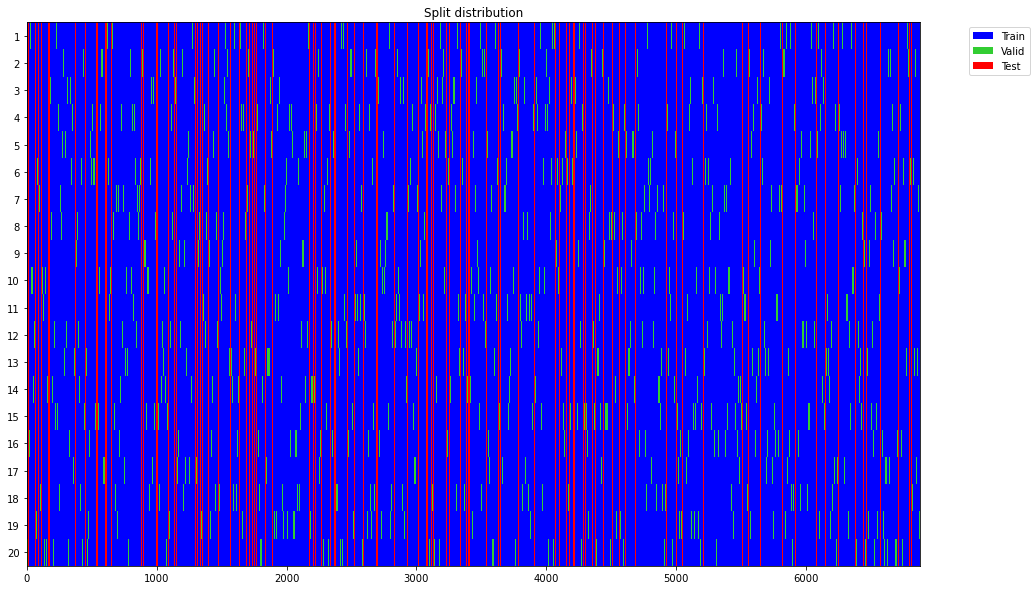

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, '1st degree av block': 722, 'premature atrial contraction': 616}


In [7]:
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
y = y[y.columns[y.sum()>0.05*len(y)] ]

cv_splits = get_splits(y.to_numpy(), n_splits = 20, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))
tfms  = [None, TSMultiLabelClassification()]



In [8]:
# no saving 
for cv_num in range(20):
#     cv_num = cv_num + 0
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi]
    if architecture == "inception":
        model = InceptionTimePlus(dls.vars, dls.c, dls.len,)
    elif architecture == "minirocket":
        model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
                    cbs=[
#                         fastai.callback.all.SaveModelCallback(monitor="F1_multi",fname="%s_%s_%s_%s_%s"%(architecture,DATASET_ID,processing_type,sf,cv_num)),
                        fastai.callback.all.EarlyStoppingCallback(monitor='F1_multi', min_delta=0.005, patience=50)
                        ],
#                     model_dir="models/scaling/"
                   )

    learn.fit_one_cycle(400, lr_max=0.01,)
#     # now test it on test set
#     learn.load("%s_%s_%s_%s_%s"%(architecture,DATASET_ID,processing_type,sf,cv_num))
#     fold_splits = cv_splits[cv_num]
#     dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
#     dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)

#     valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
#     y_pred = (valid_preds>0)
#     y_test = valid_targets
#     report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
#     df = pd.DataFrame(report).reset_index()
#     df.to_csv("models/scaling/csvs/%s_%s_%s_%s_%s.csv"%(architecture,DATASET_ID,processing_type,sf,cv_num),index=False)
#     df

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.377550,0.385236,0.868203,0.550424,1.000000,0.100847,1.000000,0.182927,00:06
1,0.314345,0.393612,0.857604,0.636717,0.522477,0.324198,0.949237,0.400057,00:06
2,0.281600,0.266890,0.895392,0.687287,0.787682,0.392940,0.981633,0.523742,00:06
3,0.258101,0.415647,0.859908,0.679779,0.527818,0.424896,0.934662,0.470707,00:06
4,0.235943,0.516480,0.844240,0.654899,0.462426,0.387026,0.922772,0.421284,00:06
5,0.215376,0.311751,0.886636,0.729127,0.642883,0.506316,0.951938,0.566382,00:06
6,0.194366,0.174102,0.930876,0.810978,0.849963,0.641384,0.980572,0.730859,00:06
7,0.183655,0.182836,0.930876,0.818454,0.831943,0.659579,0.977329,0.735562,00:06
8,0.170813,0.171539,0.934562,0.821276,0.860952,0.660924,0.981627,0.747781,00:06
9,0.162860,0.165732,0.936866,0.830068,0.860174,0.679033,0.981104,0.758112,00:06


No improvement since epoch 90: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.372851,0.382757,0.856682,0.605972,0.532959,0.250337,0.961607,0.340406,00:06
1,0.315930,0.337954,0.874194,0.653695,0.638311,0.340911,0.966479,0.442738,00:07
2,0.276312,0.348487,0.848387,0.608811,0.475266,0.268966,0.948656,0.343060,00:08
3,0.248273,0.298239,0.883871,0.734334,0.628373,0.522172,0.946495,0.569786,00:06
4,0.226820,0.234615,0.915668,0.772439,0.802164,0.569199,0.975678,0.665182,00:06
5,0.203647,0.234418,0.913364,0.762931,0.799750,0.549647,0.976214,0.651044,00:07
6,0.189413,0.223998,0.915207,0.769561,0.803603,0.562911,0.976211,0.661805,00:09
7,0.179384,0.235027,0.912903,0.793829,0.744427,0.624946,0.962712,0.679304,00:07
8,0.168959,0.221276,0.920737,0.805206,0.782322,0.641221,0.969192,0.703787,00:07
9,0.160278,0.179322,0.929032,0.812498,0.834951,0.647156,0.977839,0.728849,00:06


No improvement since epoch 151: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.354922,0.540448,0.788018,0.571462,0.267560,0.266379,0.876546,0.266902,00:10
1,0.302725,0.321105,0.885714,0.643113,0.771614,0.301320,0.984906,0.433249,00:06
2,0.268597,0.304600,0.879263,0.630394,0.715583,0.279661,0.981128,0.402076,00:07
3,0.243425,0.309050,0.882028,0.663298,0.678325,0.355172,0.971424,0.465811,00:08
4,0.223616,0.370464,0.873272,0.675361,0.595679,0.396552,0.954171,0.475908,00:06
5,0.203854,0.302571,0.885714,0.711576,0.650417,0.466298,0.956854,0.542015,00:09
6,0.188201,0.271833,0.905530,0.756376,0.734915,0.546175,0.966577,0.626423,00:11
7,0.177426,0.226937,0.911521,0.767644,0.770196,0.564951,0.970337,0.650561,00:08
8,0.166145,0.212613,0.921198,0.795786,0.796747,0.619073,0.972499,0.696253,00:06
9,0.165533,0.200031,0.922581,0.791506,0.813213,0.606735,0.976278,0.694789,00:09


No improvement since epoch 110: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.348676,0.346163,0.878341,0.616126,0.700365,0.249978,0.982275,0.368445,00:10
1,0.290278,0.282628,0.894470,0.649652,0.855285,0.307894,0.991410,0.452405,00:07
2,0.256465,0.264639,0.903226,0.711856,0.777800,0.444652,0.979060,0.565804,00:06
3,0.228978,0.265692,0.896774,0.724097,0.694118,0.483087,0.965107,0.569064,00:07
4,0.205574,0.339283,0.880184,0.699870,0.603799,0.448075,0.951666,0.514084,00:08
5,0.189535,0.238199,0.920276,0.774530,0.809222,0.571075,0.977984,0.668996,00:08
6,0.180875,0.254651,0.907373,0.753452,0.738710,0.538572,0.968332,0.622534,00:07
7,0.167787,0.193506,0.928111,0.794405,0.841781,0.607611,0.981198,0.704537,00:06
8,0.163585,0.207235,0.924885,0.810996,0.783760,0.652092,0.969900,0.711150,00:11
9,0.158113,0.185700,0.937327,0.825300,0.857386,0.668846,0.981755,0.750798,00:06


No improvement since epoch 145: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.365526,0.333471,0.877880,0.614109,0.693816,0.245944,0.982275,0.362431,00:06
1,0.304183,0.333512,0.880184,0.657234,0.647907,0.346113,0.968354,0.450999,00:06
2,0.269355,0.275797,0.891705,0.708973,0.675303,0.453897,0.964048,0.542494,00:07
3,0.245179,0.238820,0.911060,0.706520,0.892601,0.421095,0.991946,0.568608,00:06
4,0.223975,0.352065,0.871889,0.700857,0.560796,0.462336,0.939378,0.506688,00:07
5,0.202865,0.208162,0.922581,0.783584,0.809374,0.589715,0.977453,0.681732,00:07
6,0.188125,0.177242,0.931336,0.814730,0.826471,0.652019,0.977442,0.728595,00:08
7,0.176465,0.189284,0.928571,0.802114,0.829249,0.625718,0.978510,0.711977,00:06
8,0.168482,0.180447,0.933180,0.822723,0.828215,0.668552,0.976894,0.739603,00:07
9,0.159578,0.191968,0.935945,0.816233,0.865643,0.649108,0.983359,0.741841,00:09


No improvement since epoch 51: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.375318,0.377874,0.868664,0.550007,0.862944,0.102710,0.997303,0.183451,00:07
1,0.309363,0.357355,0.878341,0.642396,0.667521,0.311189,0.973603,0.424344,00:07
2,0.275507,0.313268,0.883410,0.674907,0.666673,0.382092,0.967721,0.484905,00:06
3,0.247228,0.273966,0.893548,0.690490,0.737458,0.405186,0.975795,0.521158,00:06
4,0.226567,0.287300,0.893088,0.708883,0.699686,0.450058,0.967708,0.546814,00:06
5,0.206444,0.240515,0.911982,0.760816,0.774658,0.548562,0.973070,0.642225,00:07
6,0.189889,0.244753,0.911521,0.773852,0.747953,0.580539,0.967164,0.653546,00:08
7,0.178714,0.301368,0.879724,0.715264,0.601886,0.484348,0.946179,0.536607,00:08
8,0.169510,0.221474,0.917512,0.765699,0.815018,0.552387,0.979011,0.657255,00:08
9,0.159063,0.212332,0.917051,0.792853,0.760645,0.618508,0.967198,0.681748,00:08


No improvement since epoch 66: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.379063,0.448676,0.831336,0.594286,0.365568,0.263733,0.924840,0.306303,00:06
1,0.314925,0.339381,0.880645,0.619473,0.719982,0.255053,0.983892,0.373946,00:06
2,0.279368,0.313645,0.885253,0.680318,0.658409,0.394467,0.966169,0.493342,00:06
3,0.250860,0.328980,0.866359,0.661395,0.541214,0.375414,0.947376,0.443258,00:08
4,0.228127,0.270064,0.893088,0.731478,0.659142,0.505920,0.957036,0.572357,00:09
5,0.205463,0.264254,0.906452,0.711889,0.815584,0.440414,0.983364,0.570775,00:07
6,0.190849,0.212000,0.919816,0.771756,0.812019,0.564998,0.978513,0.665397,00:08
7,0.180605,0.191021,0.932258,0.807479,0.850051,0.633212,0.981746,0.724835,00:08
8,0.171896,0.216798,0.916129,0.800732,0.734606,0.639601,0.961863,0.683762,00:07
9,0.163011,0.219252,0.920276,0.795106,0.772050,0.620295,0.969916,0.687659,00:06


No improvement since epoch 124: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.382248,0.490843,0.837327,0.588087,0.405672,0.236542,0.939633,0.298302,00:10
1,0.319122,0.333176,0.867281,0.620113,0.592070,0.271498,0.968729,0.371848,00:12
2,0.285836,0.449382,0.823963,0.620559,0.378890,0.333366,0.907753,0.354318,00:11
3,0.255817,0.363599,0.882489,0.691882,0.647762,0.423106,0.960657,0.511726,00:12
4,0.226631,0.414468,0.853456,0.679391,0.498371,0.433735,0.925047,0.463179,00:08
5,0.202363,0.292357,0.894470,0.730757,0.694734,0.499813,0.961701,0.579257,00:10
6,0.190533,0.314465,0.868664,0.731650,0.551770,0.538262,0.925037,0.543769,00:11
7,0.181951,0.228191,0.920737,0.783393,0.817427,0.589430,0.977356,0.683140,00:11
8,0.173435,0.197976,0.928111,0.778997,0.899426,0.568782,0.989212,0.695877,00:11
9,0.166179,0.310086,0.893088,0.721754,0.687302,0.480180,0.963329,0.564904,00:11


No improvement since epoch 136: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.371847,0.418304,0.871889,0.556704,0.871541,0.116632,0.996776,0.204652,00:08
1,0.309329,0.324987,0.876959,0.621928,0.666264,0.265868,0.977988,0.380032,00:08
2,0.271995,0.517830,0.830415,0.612035,0.379580,0.307283,0.916788,0.339599,00:06
3,0.247283,0.336805,0.880184,0.656080,0.644001,0.343289,0.968870,0.447839,00:06
4,0.226320,0.670305,0.819816,0.615308,0.355200,0.329938,0.900677,0.342082,00:08
5,0.205463,0.271994,0.894470,0.737959,0.663871,0.519427,0.956490,0.582663,00:08
6,0.188092,0.261978,0.900461,0.751722,0.685220,0.544240,0.959204,0.606083,00:08
7,0.177133,0.214655,0.917972,0.773215,0.793403,0.571142,0.975287,0.663668,00:08
8,0.166431,0.329958,0.873733,0.690350,0.570440,0.434409,0.946291,0.492724,00:07
9,0.160737,0.183227,0.932719,0.818301,0.831965,0.658616,0.977987,0.735080,00:06


No improvement since epoch 169: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.368901,0.390893,0.870968,0.538286,1.000000,0.076572,1.000000,0.141642,00:08
1,0.314213,0.424252,0.848848,0.602095,0.429984,0.259890,0.944300,0.323778,00:07
2,0.275110,0.279511,0.894470,0.635298,0.888745,0.275941,0.994654,0.420756,00:06
3,0.249134,0.272012,0.893548,0.675165,0.732984,0.372274,0.978055,0.493716,00:06
4,0.222700,0.384480,0.866820,0.687852,0.529039,0.439431,0.936273,0.479665,00:08
5,0.202958,0.355913,0.875576,0.702812,0.564297,0.462939,0.942686,0.507848,00:10
6,0.189766,0.233537,0.913364,0.762941,0.760625,0.554267,0.971615,0.640644,00:09
7,0.181821,0.308888,0.879724,0.733421,0.574242,0.530570,0.936272,0.551532,00:10
8,0.173267,0.222882,0.916590,0.775745,0.765447,0.580417,0.971072,0.659549,00:06
9,0.166986,0.211150,0.918894,0.778443,0.779070,0.583663,0.973224,0.667351,00:07


No improvement since epoch 121: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.355378,0.414705,0.840499,0.616285,0.402970,0.306088,0.926482,0.347738,00:11
1,0.300508,0.509341,0.840499,0.571759,0.363805,0.199882,0.943635,0.257875,00:08
2,0.270818,0.382468,0.846047,0.664094,0.439642,0.412441,0.915747,0.425590,00:07
3,0.248339,0.267287,0.901063,0.684999,0.788933,0.386091,0.983906,0.518138,00:06
4,0.230671,0.278920,0.901063,0.698991,0.754569,0.419446,0.978537,0.538532,00:07
5,0.208622,0.447034,0.864540,0.691932,0.512624,0.453101,0.930763,0.480634,00:07
6,0.192802,0.238454,0.910772,0.754977,0.743761,0.539470,0.970483,0.624928,00:07
7,0.182347,0.209883,0.921405,0.789099,0.776156,0.606110,0.972087,0.679407,00:07
8,0.170719,0.252956,0.908923,0.787633,0.691477,0.619813,0.955454,0.653642,00:07
9,0.166917,0.210600,0.925104,0.792736,0.804011,0.609632,0.975840,0.692109,00:08


No improvement since epoch 20: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.364668,0.412057,0.849746,0.599333,0.432239,0.251850,0.946817,0.317538,00:08
1,0.303493,0.318345,0.889505,0.647555,0.760405,0.311756,0.983353,0.439335,00:08
2,0.267942,0.299163,0.896903,0.709857,0.701818,0.450335,0.969380,0.547297,00:09
3,0.239240,0.333894,0.872862,0.676626,0.563415,0.404301,0.948950,0.470657,00:10
4,0.217814,0.243005,0.910310,0.727273,0.803168,0.473349,0.981196,0.595645,00:09
5,0.198075,0.264856,0.904300,0.758479,0.696728,0.556185,0.960773,0.618350,00:09
6,0.188748,0.205479,0.923717,0.796610,0.788605,0.620096,0.973123,0.694036,00:10
7,0.177918,0.191091,0.930190,0.797361,0.844885,0.612987,0.981736,0.710173,00:10
8,0.172536,0.217826,0.924642,0.788560,0.811093,0.599696,0.977424,0.689416,00:08
9,0.165821,0.195051,0.932039,0.806417,0.841119,0.632176,0.980658,0.721822,00:08


No improvement since epoch 34: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.364927,0.374690,0.867776,0.590924,0.699502,0.197027,0.984821,0.306258,00:06
1,0.298931,0.353534,0.875636,0.617621,0.758360,0.250401,0.984842,0.373041,00:07
2,0.261670,0.262012,0.901063,0.703110,0.828041,0.421398,0.984821,0.557631,00:08
3,0.237685,0.287709,0.898289,0.690528,0.831027,0.394625,0.986432,0.533083,00:06
4,0.213433,0.233579,0.911697,0.741989,0.837889,0.500767,0.983210,0.626779,00:06
5,0.197811,0.238706,0.908923,0.742315,0.810633,0.505230,0.979400,0.621762,00:08
6,0.183047,0.225969,0.919556,0.793964,0.799131,0.615055,0.972872,0.694102,00:08
7,0.175169,0.203102,0.921868,0.790150,0.824508,0.602575,0.977725,0.696033,00:08
8,0.168666,0.227838,0.920943,0.807589,0.784871,0.646097,0.969080,0.707829,00:09
9,0.164991,0.246492,0.908460,0.769730,0.754076,0.572020,0.967440,0.649255,00:08


No improvement since epoch 132: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.360694,0.474500,0.804438,0.574471,0.300313,0.249608,0.899335,0.272294,00:06
1,0.302446,0.483577,0.826167,0.602860,0.374664,0.287479,0.918242,0.324966,00:06
2,0.270160,0.676450,0.803514,0.596313,0.318820,0.303600,0.889026,0.310813,00:06
3,0.242199,0.356615,0.864078,0.649079,0.556160,0.345261,0.952897,0.425582,00:06
4,0.223127,0.324750,0.882108,0.694043,0.643642,0.428140,0.959945,0.512083,00:08
5,0.202948,0.356726,0.883033,0.703567,0.641665,0.449924,0.957209,0.528746,00:06
6,0.186661,0.246707,0.914008,0.774537,0.775621,0.577241,0.971834,0.659863,00:08
7,0.174320,0.322015,0.874711,0.729757,0.580089,0.525011,0.934504,0.550971,00:08
8,0.167152,0.294493,0.895053,0.753604,0.671400,0.553787,0.953421,0.606849,00:09
9,0.160437,0.233371,0.915395,0.791628,0.758427,0.616823,0.966432,0.680321,00:06


No improvement since epoch 32: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.364135,0.425039,0.834489,0.603533,0.396110,0.278918,0.928149,0.327089,00:08
1,0.311829,0.352369,0.878410,0.641178,0.671448,0.307749,0.974608,0.421769,00:06
2,0.273490,0.455533,0.829404,0.632474,0.397807,0.355707,0.909241,0.375559,00:06
3,0.251041,0.298806,0.895978,0.692774,0.763651,0.407155,0.978393,0.529776,00:08
4,0.228132,0.339408,0.886269,0.720416,0.638442,0.487295,0.953537,0.552574,00:09
5,0.206248,0.306458,0.883033,0.717155,0.621497,0.484014,0.950296,0.544071,00:07
6,0.189923,0.241589,0.910310,0.751824,0.777386,0.529040,0.974607,0.629045,00:08
7,0.175978,0.339966,0.881184,0.728061,0.605167,0.512845,0.943278,0.554393,00:08
8,0.170077,0.222586,0.918632,0.780637,0.795334,0.586666,0.974608,0.674929,00:09
9,0.157684,0.233200,0.913084,0.760121,0.784864,0.545096,0.975146,0.642270,00:07


No improvement since epoch 20: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.359835,0.398781,0.841886,0.581523,0.396819,0.218504,0.944541,0.281272,00:08
1,0.311309,0.837870,0.772076,0.539485,0.207437,0.215178,0.863792,0.211081,00:09
2,0.278069,0.312141,0.887194,0.671008,0.689055,0.369470,0.972545,0.480305,00:06
3,0.256010,0.382323,0.859917,0.639956,0.508177,0.333212,0.946700,0.402319,00:10
4,0.235169,0.269104,0.893204,0.704651,0.693064,0.441617,0.967685,0.539068,00:08
5,0.212101,0.242468,0.909385,0.756331,0.747861,0.542819,0.969843,0.628839,00:06
6,0.192638,0.242381,0.907074,0.756257,0.727198,0.545903,0.966611,0.622167,00:12
7,0.179945,0.368839,0.867776,0.712978,0.535185,0.497047,0.928909,0.515384,00:06
8,0.171646,0.222972,0.916320,0.775289,0.772856,0.578584,0.971994,0.661737,00:08
9,0.162353,0.215747,0.916782,0.797540,0.743287,0.631181,0.963899,0.682642,00:12


No improvement since epoch 132: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.371387,0.344319,0.881184,0.587313,0.899311,0.177864,0.996763,0.296754,00:07
1,0.315143,0.337339,0.884882,0.614150,0.818935,0.236906,0.991394,0.366848,00:07
2,0.275161,0.323817,0.889968,0.653308,0.756150,0.323309,0.983307,0.451721,00:07
3,0.248801,0.596052,0.829404,0.611675,0.374497,0.308402,0.914948,0.338136,00:06
4,0.226716,0.345014,0.869626,0.677243,0.550005,0.409370,0.945116,0.469299,00:07
5,0.208490,0.290204,0.898752,0.701295,0.747695,0.426287,0.976304,0.542973,00:06
6,0.191654,0.329925,0.884420,0.709336,0.619802,0.465510,0.953163,0.531649,00:06
7,0.181405,0.227966,0.919556,0.777900,0.795314,0.580574,0.975225,0.670734,00:07
8,0.176796,0.241682,0.908460,0.751224,0.748132,0.532003,0.970445,0.620150,00:08
9,0.166658,0.218194,0.919094,0.766010,0.815386,0.552488,0.979531,0.658329,00:08


No improvement since epoch 136: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.359186,0.371798,0.859455,0.592741,0.526601,0.218411,0.967071,0.308695,00:12
1,0.310413,0.483821,0.815534,0.616410,0.352324,0.337040,0.895780,0.344444,00:09
2,0.269580,0.324032,0.874711,0.680978,0.595803,0.408986,0.952969,0.484764,00:08
3,0.244498,0.379206,0.860379,0.661820,0.517320,0.383067,0.940574,0.439914,00:08
4,0.219569,0.245102,0.912621,0.751136,0.798123,0.524405,0.977868,0.632731,00:07
5,0.200221,0.201837,0.928340,0.787359,0.873425,0.589337,0.985381,0.703773,00:06
6,0.187985,0.204565,0.924179,0.786263,0.833658,0.592538,0.979989,0.692599,00:07
7,0.175882,0.186575,0.932039,0.803917,0.867371,0.624033,0.983801,0.725594,00:07
8,0.165111,0.186827,0.930652,0.810514,0.839998,0.641557,0.979472,0.727021,00:06
9,0.160094,0.189068,0.928803,0.814743,0.816743,0.654335,0.975150,0.725836,00:06


No improvement since epoch 98: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.374503,0.372857,0.870088,0.546083,0.861136,0.094311,0.997854,0.169647,00:06
1,0.319975,0.364135,0.854831,0.611329,0.476583,0.271662,0.950996,0.345912,00:08
2,0.283869,0.533563,0.821082,0.624520,0.360950,0.350295,0.898745,0.355305,00:09
3,0.254429,0.303230,0.884420,0.671154,0.664710,0.373587,0.968721,0.478283,00:08
4,0.238850,0.528319,0.845585,0.648791,0.442636,0.374068,0.923514,0.405030,00:07
5,0.218491,0.329249,0.885807,0.658096,0.699402,0.340390,0.975802,0.456438,00:07
6,0.199158,0.778645,0.856218,0.672148,0.489501,0.415414,0.928881,0.449121,00:07
7,0.189025,0.210158,0.920019,0.771284,0.814273,0.563568,0.978999,0.665375,00:08
8,0.175553,0.299539,0.897365,0.742853,0.677475,0.527202,0.958504,0.592937,00:06
9,0.171684,0.234447,0.914933,0.778279,0.757035,0.587261,0.969297,0.660371,00:07


No improvement since epoch 22: early stopping


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.356574,0.410577,0.884420,0.600733,0.895239,0.205790,0.995676,0.333457,00:11
1,0.297900,0.395781,0.851133,0.610673,0.460220,0.275701,0.945644,0.343840,00:08
2,0.261940,0.308732,0.882571,0.654329,0.668614,0.336141,0.972517,0.447152,00:06
3,0.234266,0.253660,0.905687,0.716973,0.784996,0.454413,0.979533,0.575031,00:07
4,0.208608,0.243128,0.909847,0.750034,0.760787,0.527557,0.972510,0.622402,00:11
5,0.193667,0.253548,0.907536,0.724025,0.790909,0.468525,0.979526,0.588138,00:09
6,0.180874,0.383955,0.876098,0.708772,0.575055,0.475718,0.941825,0.520602,00:06
7,0.171756,0.210442,0.925104,0.795951,0.807975,0.616152,0.975751,0.698891,00:10
8,0.161273,0.402371,0.860841,0.716665,0.506742,0.515721,0.917608,0.511127,00:06
9,0.155186,0.198099,0.929265,0.799538,0.838899,0.619024,0.980051,0.711852,00:08


No improvement since epoch 18: early stopping


In [4]:
for cv_num in range(20):
#     cv_num = cv_num + 0
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi]
    if architecture == "inception":
        model = InceptionTimePlus(dls.vars, dls.c, dls.len,)
    elif architecture == "minirocket":
        model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[fastai.callback.all.SaveModelCallback(
                        monitor="F1_multi",fname="%s_%s_%s_%s_%s"%(architecture,DATASET_ID,processing_type,sf,cv_num)),
                        fastai.callback.all.EarlyStoppingCallback(monitor='F1_multi', min_delta=0.005, patience=50)
                        ],
                    model_dir="models/scaling/")

    learn.fit_one_cycle(400, lr_max=0.01,)
    # now test it on test set
    learn.load("%s_%s_%s_%s_%s"%(architecture,DATASET_ID,processing_type,sf,cv_num))
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)

    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    y_pred = (valid_preds>0)
    y_test = valid_targets
    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    df = pd.DataFrame(report).reset_index()
    df.to_csv("models/scaling/csvs/%s_%s_%s_%s_%s.csv"%(architecture,DATASET_ID,processing_type,sf,cv_num),index=False)
    df

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time



KeyboardInterrupt

